In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
import os
import random
from matplotlib import pyplot as plt
from tqdm import tqdm

from lstm_utils import EarthquakePredictionModel

def set_seed(seed):
    torch.manual_seed(seed)
    
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    np.random.seed(seed)
    random.seed(seed)
    
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
dataset_variants = [
    {"data_type": "orig", "min_magn": 3.5, "mode": "count", "horizon": 1},
    {"data_type": "orig", "min_magn": 3.5, "mode": "count", "horizon": 30},
    {"data_type": "orig", "min_magn": 3.5, "mode": "max", "horizon": 1},
    {"data_type": "orig", "min_magn": 3.5, "mode": "max", "horizon": 30},
    
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "count", "horizon": 1},
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "count", "horizon": 30},
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "max", "horizon": 1},
    {"data_type": "withoutfat", "min_magn": 3.5, "mode": "max", "horizon": 30},
    
    {"data_type": "orig", "min_magn": 6.0, "mode": "count", "horizon": 1},
    {"data_type": "orig", "min_magn": 6.0, "mode": "count", "horizon": 30},
    {"data_type": "orig", "min_magn": 6.0, "mode": "max", "horizon": 1},
    {"data_type": "orig", "min_magn": 6.0, "mode": "max", "horizon": 30},
    
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "count", "horizon": 1},
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "count", "horizon": 30},
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "max", "horizon": 1},
    {"data_type": "withoutfat", "min_magn": 6.0, "mode": "max", "horizon": 30},
]

In [4]:
from scipy.ndimage import gaussian_filter


class EarthquakeDataset(Dataset):
    def __init__(
        self, 
        path, 
        target_path,
        baseline_history_days=5*365,
        sigma=0.0, 
        seq_len=30, 
        stride=30,
        history_horizon=1,
        pred_horizon_min=10, 
        pred_horizon_max=50,
        dataset_type="train",
        n=160,
        m=180,
        x_min=None,
        x_max=None,
    ):
        """
        Args:
            path: Path to input data tensor of shape [total_timesteps, H, W]
            target_path: Path to target data tensor of shape [total_timesteps, H, W]
            baseline_history_days: Days to aggregate for baseline map
            seq_len: Input sequence length
            stride: Sliding window step
            pred_horizon_min/max: Range of days to predict (binary target)
            dataset_type: "train" or "test"
            x_mean/x_std: Precomputed mean/std (for test set)
        """
        assert dataset_type in ["train", "test"]
    
        self.data = torch.load(path).to(torch.float)  # [T, H, W]
        self.target = torch.load(target_path).to(torch.float)  # [T, H, W]
        if dataset_type == "train":
            self.data = self.data[:-1000]
            self.target = self.target[:-1000]
        elif dataset_type == "test":
            self.data = self.data[-(baseline_history_days+1000):]
            self.target = self.target[-(baseline_history_days+1000):]
            
        self.seq_len = seq_len
        self.stride = stride
        self.n = n
        self.m = m
        self.history_horizon = history_horizon
        self.baseline_history_days = baseline_history_days
        self.pred_horizon_min = pred_horizon_min
        self.pred_horizon_max = pred_horizon_max
        self.dataset_type = dataset_type
        self.sigma = sigma

        # Compute valid clips (avoid out-of-bounds)
        self.total_clips = (
            (len(self.data) - baseline_history_days - seq_len - pred_horizon_max - history_horizon) 
            // stride + 1
        )
        assert self.total_clips > 0, "Dataset is too short for given seq_len/pred_horizon!"

        # Normalization
        if dataset_type == "train":
            self.x_min, self.x_max = self._compute_min_max()
        else:
            assert x_min is not None and x_max is not None, "Test set requires precomputed min/max!"
            self.x_min, self.x_max = x_min, x_max

    def _compute_min_max(self):
        all_sequences = []

        for idx in range(self.total_clips):
            start = self.baseline_history_days + idx * self.stride
            window_starts = torch.arange(
                start,
                start + self.seq_len * self.stride,
                self.stride,
                device=self.data.device
            )
            window_ends = window_starts + self.history_horizon
            x = torch.stack([self.data[s:e].sum(0) for s, e in zip(window_starts, window_ends)])
            all_sequences.append(x)

        all_sequences = torch.stack(all_sequences)
        x_min = torch.amin(all_sequences, dim=(0, 1))
        x_max = torch.amax(all_sequences, dim=(0, 1))
        
        return x_min, x_max

    def min_max_scale(self, x):
        if self.x_min is not None and self.x_max is not None:
            mask = x > 0
            x_min_expanded = self.x_min.unsqueeze(0).expand_as(x)
            x_max_expanded = self.x_max.unsqueeze(0).expand_as(x)
            x[mask] = (x[mask] - x_min_expanded[mask]) / (x_max_expanded[mask] - x_min_expanded[mask] + 1e-8)
            x[mask] = x[mask].clamp(0, 1)
        
        return x

    def __len__(self):
        return self.total_clips

    def __getitem__(self, idx):
        start = self.baseline_history_days + idx*self.stride + self.history_horizon # do not take first baseline_history_days
        
        # 1. Input sequence
        window_starts = torch.arange(
            start,
            start + self.seq_len * self.stride,
            self.stride,
            device=self.data.device
        )
        window_ends = window_starts + self.history_horizon
        x = torch.stack([self.data[s:e].sum(0) for s, e in zip(window_starts, window_ends)])
        if self.x_min is not None:
            x = self.min_max_scale(x) 

        # 2. Baseline calculation
        baseline_map = self.target[start-self.baseline_history_days:start].sum(0)
        baseline_map = gaussian_filter(baseline_map, sigma=self.sigma)
        if baseline_map.max() > 0:
            baseline_map /= baseline_map.max() + 1e-8 
        baseline_map = torch.tensor(baseline_map+ 1e-8, dtype=torch.float32)

        # 3. Concatenate
        x = torch.cat([x, baseline_map.unsqueeze(0)]) # [seq_len+1, H, W]

        # 4. Binary target (did any event occur in the horizon?)
        last_x_idx = window_ends[-1].numpy()
        y = (
            self.target[
                last_x_idx + self.pred_horizon_min:
                last_x_idx + self.pred_horizon_max
            ].sum(dim=0) > 0
        )  # [H, W], binary

        return x.to(torch.float16), y.to(torch.float16)

# check data

In [45]:
dataset_variant = dataset_variants[1]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/orig_3.5_count', 'data/orig_3.5_count')

In [46]:
celled_data = torch.load(pn).to(torch.float16)
celled_data.shape

torch.Size([7064, 160, 180])

In [47]:
dataset_variant

{'data_type': 'orig', 'min_magn': 3.5, 'mode': 'count', 'horizon': 30}

In [48]:
batch_size=1
stride=30
seq_len=1
history_horizon=64

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=1.5
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=1.5
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [49]:
train_dataset.x_min.min(), train_dataset.x_max.min()

(tensor(0.), tensor(0.))

In [50]:
train_dataset.pred_horizon_min, train_dataset.pred_horizon_max

(10, 50)

In [51]:
train_dataset.x_min.max(), train_dataset.x_max.max()

(tensor(0.), tensor(74.))

In [52]:
len(train_dataset), len(test_dataset)

(138, 30)

In [53]:
x, y = train_dataset[1]
print(x.shape, y.shape)
x[0].min(), x[0].max()

torch.Size([2, 160, 180]) torch.Size([160, 180])


(tensor(0., dtype=torch.float16), tensor(1., dtype=torch.float16))

In [54]:
np.unique(x[0].numpy())

array([0.     , 0.01755, 0.03333, 0.06665, 0.0833 , 0.0909 , 0.1    ,
       0.1111 , 0.125  , 0.1428 , 0.1666 , 0.25   , 0.3333 , 0.4285 ,
       0.5    , 0.75   , 0.8    , 1.     ], dtype=float16)

In [55]:
np.unique(x[1].numpy())

array([0.000e+00, 5.960e-08, 1.192e-07, ..., 8.530e-01, 8.687e-01,
       1.000e+00], dtype=float16)

In [56]:
np.unique(y.numpy())

array([0., 1.], dtype=float16)

In [59]:
def plot_x_y(x, y, title=""):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    array = (x[0].transpose(0, 1)).numpy()[::-1]
    axes[0].imshow(array, cmap='viridis')
    axes[0].set_title(f"input | index {title}")
    axes[0].set_xlabel('x (lon)')
    axes[0].set_ylabel('y (lat)')
    fig.colorbar(axes[0].imshow(array, cmap='viridis'), ax=axes[0], label='Values')

    array = (x[1].transpose(0, 1)).numpy()[::-1]
    axes[1].imshow(array, cmap='viridis')
    axes[1].set_title(f"baseline map | index {title}")
    axes[1].set_xlabel('x (lon)')
    axes[1].set_ylabel('y (lat)')
    fig.colorbar(axes[1].imshow(array, cmap='viridis'), ax=axes[1], label='Values')

    array = (y.transpose(0, 1)).numpy()[::-1]
    axes[2].imshow(array, cmap='viridis')
    axes[2].set_title(f"target | index {title}")
    axes[2].set_xlabel('x (lon)')
    axes[2].set_ylabel('y (lat)')
    fig.colorbar(axes[2].imshow(array, cmap='viridis'), ax=axes[2], label='Values')

    plt.tight_layout()
    plt.show()

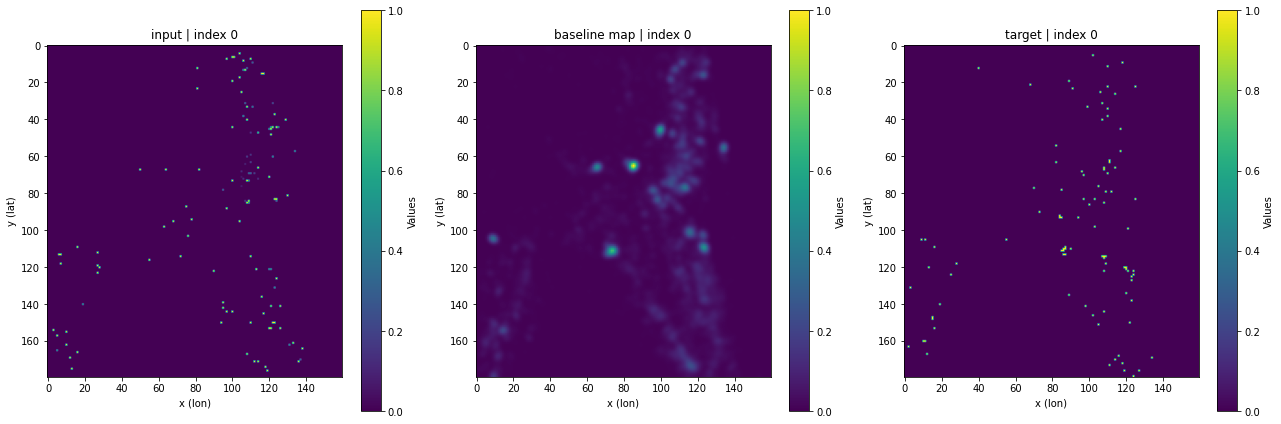

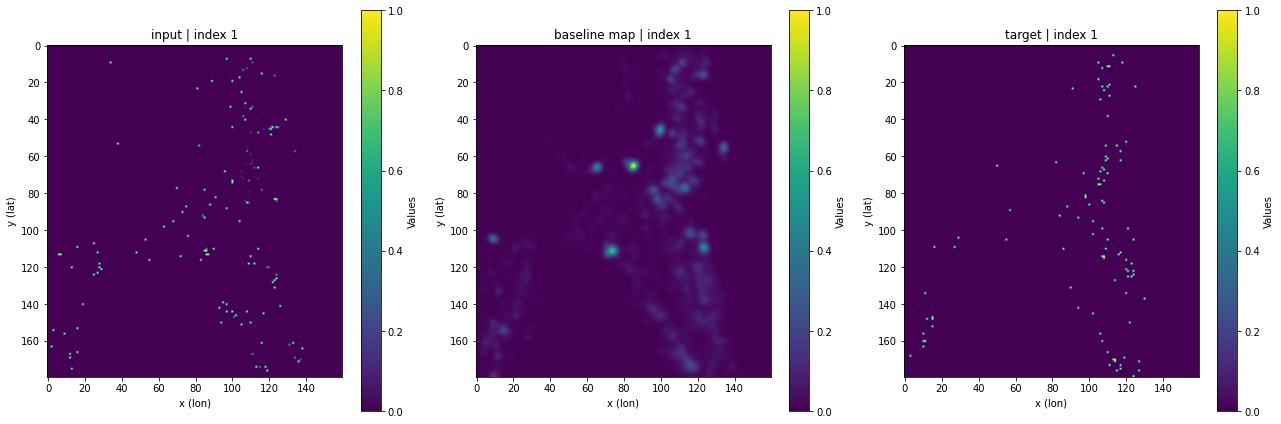

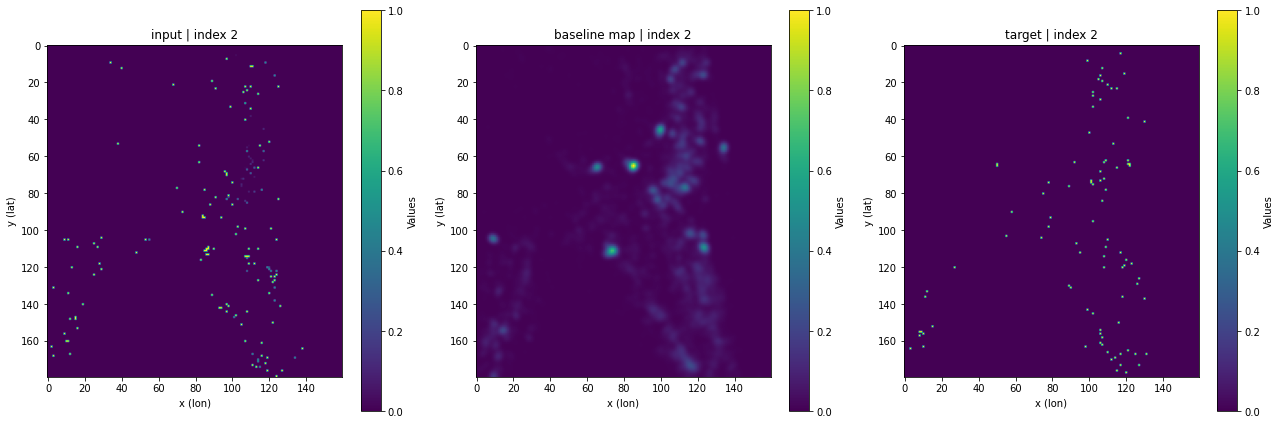

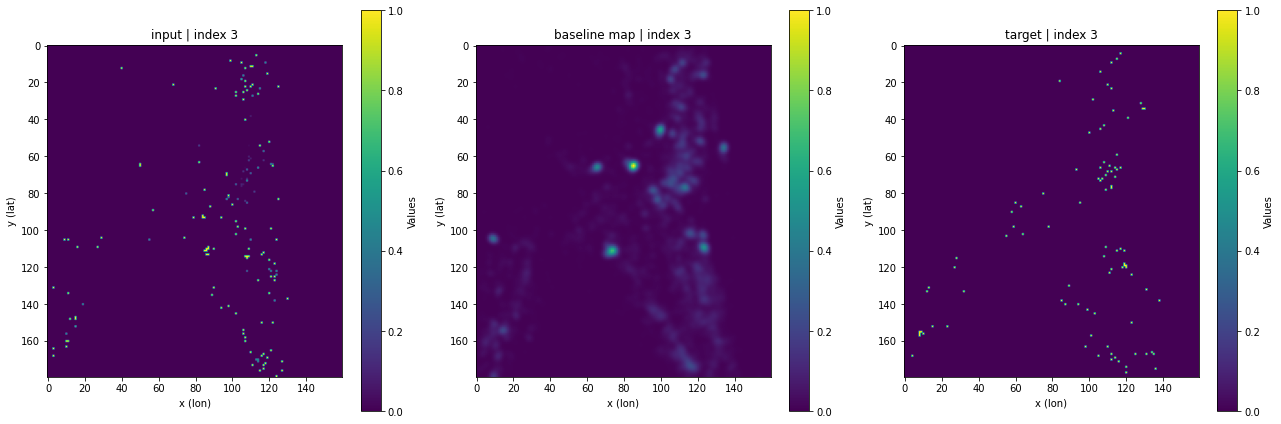

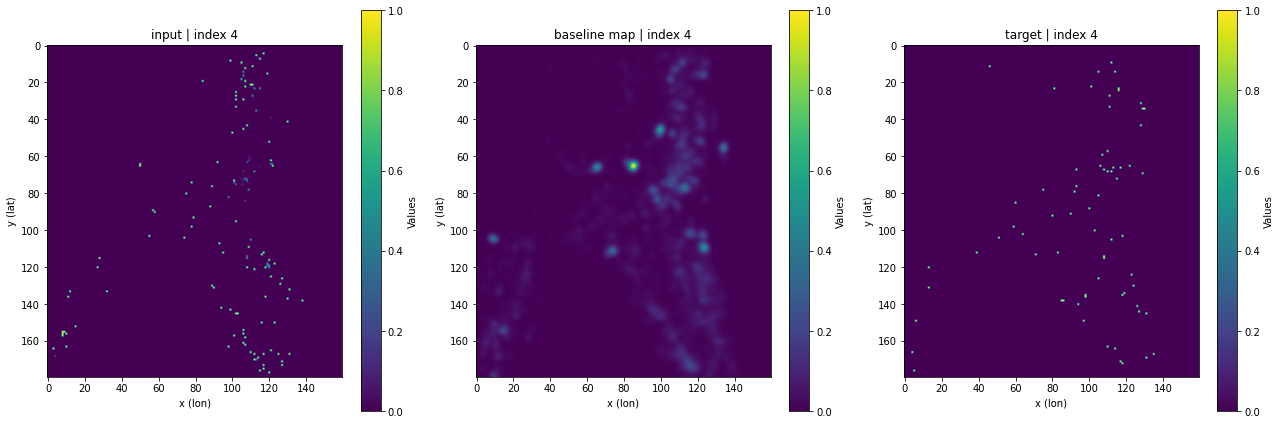

In [60]:
for i in range(5): #range(len(train_dataset)):
    x,y = train_dataset[i]
    if x[0].max() > 0 or y.max() > 0:
        plot_x_y(x, y, title=i)

In [17]:
# x,y = train_dataset[0]
# if x[0].max() > 0 or y.max() > 0:
#     plot_x_y(x, y, title=i)

# model

In [5]:
import gc
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.cuda.amp import autocast, GradScaler
from IPython.display import clear_output
from sklearn.metrics import auc

In [23]:
def precision_tpr_fpr(input, target, threshold, sample_weight=None, method="weight", device=torch.device("cpu")):
    """sample_weight is used only for fpr"""
    
    assert method in ["weight", "mask"], f"unknown method: {method}"
    
    if sample_weight is None:
        sample_weight = torch.ones_like(target).float()
        
    sample_weight = sample_weight.to(device)
    
    if method=="weight":
        TP = torch.sum(((input > threshold).float() * target).float())
        FP = torch.sum(((input > threshold).float() * (1 - target)).float() * sample_weight)
        FN = torch.sum(((~(input > threshold)).float() * target).float())
        TN = torch.sum(((~(input > threshold)).float() * (1 - target)).float() * sample_weight)
    elif method=="mask":
        sample_weight = (sample_weight > 0).float()
        
        TP = torch.sum(((input > threshold).float() * target).float() * sample_weight)
        FP = torch.sum(((input > threshold).float() * (1 - target)).float() * sample_weight)
        FN = torch.sum(((~(input > threshold)).float() * target).float() * sample_weight)
        TN = torch.sum(((~(input > threshold)).float() * (1 - target)).float() * sample_weight)

    return (TP, TP + FN), TP / (TP + FN), FP / (FP + TN)

def calc_roc(target, prediction, weights=None, method="weight", n_dots=500, device=torch.device("cpu"), tqdm_on=False):
    fpr = []
    tpr = []
    trs = np.linspace(-0.0001, 1.02, n_dots)
    if weights is None:
        desc = "roc auc"
    else:
        desc = "weighted fpr roc auc"
    for t in tqdm(trs, desc=desc, leave=False, disable=~tqdm_on):
        _, _tpr, _fpr = precision_tpr_fpr(prediction, target, t, sample_weight=weights, method=method, device=device)
        fpr.append(_fpr.cpu().numpy())
        tpr.append(_tpr.cpu().numpy())
       
    fpr = np.asarray(fpr)
    tpr = np.asarray(tpr)
    mask = ((~np.isnan(fpr)) & (~np.isnan(tpr)))
    fpr = fpr[mask]
    tpr = tpr[mask]
    roc_auc = auc(fpr, tpr)
    
    return roc_auc, tpr, fpr


def min_max_scale(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    scaled_tensor = (tensor - min_val) / (max_val - min_val)
    
    return scaled_tensor

sigmoid = nn.Sigmoid()

def plot_predictions(outputs, y, epoch, directory="model", save=False):
    os.makedirs(directory, exist_ok=True)
    plot=True
    for i in range(outputs.shape[0]):
        if save or plot:
            o = outputs[i, ...].squeeze(0).cpu().detach()
            array = o.transpose(0, 1).numpy()[::-1]
            plt.figure(figsize=(8, 6))
            plt.imshow(array, cmap='viridis', label="Prediction")
            plt.colorbar(label='Values')
            plt.xlabel('x (lon)')
            plt.ylabel('y (lat)')
            plt.title(f"epoch: {epoch}")

            target = y[i, ...].squeeze(0).cpu().detach().transpose(0, 1).numpy()
            y_indices, x_indices = np.where(target == 1)
            plt.scatter(x_indices, array.shape[0] - y_indices - 1, color='red', s=5, label='Target')
            plt.savefig(f"{directory}/epoch{epoch}_{i}.png", dpi=200)
            if target.sum()>0 and array.sum()>0 and plot==True:
                plt.show()
                plot=False
            plt.clf()
            plt.close()
        

def plot_metrics(history_loss, history_roc, history_roc_m, history_roc_w, num_epochs):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    axes[0, 0].plot(range(1, num_epochs + 1), history_loss, color='blue')
    axes[0, 0].set_title('Loss over Epochs')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].grid(alpha=0.4)

    axes[0, 1].plot(range(1, num_epochs + 1), history_roc, color='green')
    axes[0, 1].set_title('ROC over Epochs')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('ROC')
    axes[0, 1].grid(alpha=0.4)
    
    axes[1, 0].plot(range(1, num_epochs + 1), history_roc_m, color='orange')
    axes[1, 0].set_title('Masked ROC over Epochs')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Masked ROC')
    axes[1, 0].grid(alpha=0.4)

    axes[1, 1].plot(range(1, num_epochs + 1), history_roc_w, color='red')
    axes[1, 1].set_title('Weighted ROC over Epochs')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Weighted ROC')
    axes[1, 1].grid(alpha=0.4)

    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, sample_weight, device):
    model.eval()
    y_stack, outputs_stack = None, None
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            outputs = sigmoid(model(x))

            if y_stack is None:
                y_stack, outputs_stack = y, outputs
            else:
                y_stack = torch.cat((y_stack, y), dim=0)
                outputs_stack = torch.cat((outputs_stack, outputs), dim=0)
                outputs_stack = outputs_stack

    return y_stack, outputs_stack

def train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=False, 
    model_name="model", save_plots=False, min_save_epoch=2,
):
    gc.collect()
    torch.cuda.empty_cache()
    
    scaler = GradScaler() if use_amp else None
    
    history_loss, history_roc, history_roc_m, history_roc_w, res_dicts = [], [], [], [], []
    best_roc_w = 0.0
    best_model_state = None

    for epoch in range(num_epochs):
        model.train()
        for cell in model.convlstm.cell_list:
            cell.hidden_state = None
            
        running_loss = 0.0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            
            if use_amp:
                with autocast():
                    outputs = model(x)
                    loss = criterion(outputs, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()
            
            running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        history_loss.append(epoch_loss)
        
        y_stack, outputs_stack = evaluate_model(model, test_loader, sample_weight, device)
        plot_predictions(outputs_stack, y_stack, epoch, f"model/{model_name}", save=save_plots)

        sample_weight_stack = sample_weight.repeat(y_stack.shape[0], 1, 1).to(device)

        try:
            roc, tpr, fpr = calc_roc(y_stack, outputs_stack, weights=None, device=device)
            roc_m, tpr_m, fpr_m = calc_roc(y_stack, outputs_stack, weights=sample_weight_stack, method="mask", device=device)
        except:
            roc, tpr, fpr = None, np.array([None]), np.array([None])
            roc_m, tpr_m, fpr_m = None, np.array([None]), np.array([None])
        try:
            roc_w, tpr_w, fpr_w = calc_roc(y_stack, outputs_stack, weights=sample_weight_stack, method="weight", device=device)
        except:
            roc_w, tpr_w, fpr_w = None, np.array([None]), np.array([None])
            
        history_roc.append(roc)
        history_roc_m.append(roc_m)
        history_roc_w.append(roc_w)

        res_dict = {
            "epoch": epoch,
            "roc": roc,
            "tpr": tpr.tolist(),
            "fpr": fpr.tolist(),
            "roc_m": roc_m,
            "tpr_m": tpr_m.tolist(),
            "fpr_m": fpr_m.tolist(),
            "roc_w": roc_w,
            "tpr_w": tpr_w.tolist(),
            "fpr_w": fpr_w.tolist(),
            "epoch_loss": epoch_loss,
        }
        res_dicts.append(res_dict)
        if roc is not None and roc_w is not None:
            print(f"[{epoch+1}/{num_epochs}] | roc: {np.around(roc, 4)}, roc_m: {np.around(roc_m, 4)}, roc_w: {np.around(roc_w, 4)}, epoch_loss: {epoch_loss:.4f}, lr: {optimizer.param_groups[0]['lr']:.4f}")
        else:
            print(f"[{epoch+1}/{num_epochs}] | roc: {roc}, roc_m: {roc_m}, roc_w: {roc_w}, epoch_loss: {epoch_loss:.4f}, lr: {optimizer.param_groups[0]['lr']:.4f}")

        if roc_m is not None and roc_w is not None and roc_w > best_roc_w and roc_m > 0.5 and epoch>min_save_epoch-1:
            best_roc_w = roc_w
            best_model_state = model.state_dict()
            best_res_dict = res_dict

        scheduler.step()

    plot_metrics(history_loss, history_roc, history_roc_m, history_roc_w, num_epochs)

    if best_model_state is not None:
        torch.save(best_model_state, f'model/{model_name}.pth')
        best_res_dict["history_loss"] = history_loss
        best_res_dict["history_roc"] = history_roc
        best_res_dict["history_roc_m"] = history_roc_m
        best_res_dict["history_roc_w"] = history_roc_w
        with open(f'model/{model_name}.json', 'w') as json_file:
            json.dump(best_res_dict, json_file, indent=4)
        print(f"Best model saved with weighted ROC: {best_roc_w:.4f}")
        
    gc.collect()
    torch.cuda.empty_cache()

    return history_loss, history_roc, history_roc_w, res_dicts

In [7]:
# weights for fpr in roc auc
weights_data = torch.load("data/orig_3.0_count").to(torch.float)
sample_weight = weights_data[:-1000].sum(axis=0)
sample_weight /= sample_weight.max()
sample_weight = sample_weight.to(torch.float16)

sample_weight.shape, sample_weight.min(), sample_weight.max()

(torch.Size([160, 180]),
 tensor(0., dtype=torch.float16),
 tensor(1., dtype=torch.float16))

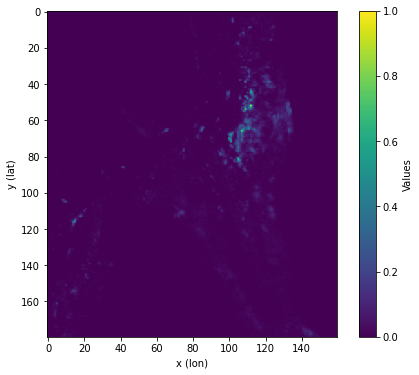

In [8]:
array = (sample_weight.transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

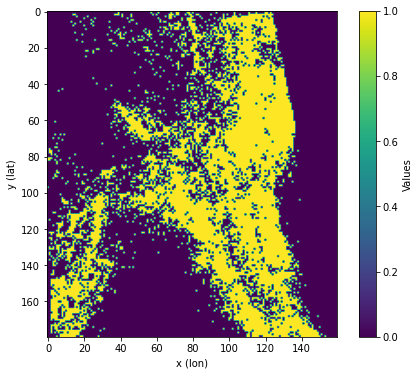

In [9]:
array = (sample_weight.transpose(0, 1) > 0).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

# M>3.5 mainshocks&aftershocks

In [179]:
dataset_variant = dataset_variants[0]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/orig_3.5_count', 'data/orig_3.5_count')

In [180]:
batch_size=1
stride=30
seq_len=1
history_horizon=64

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test"
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

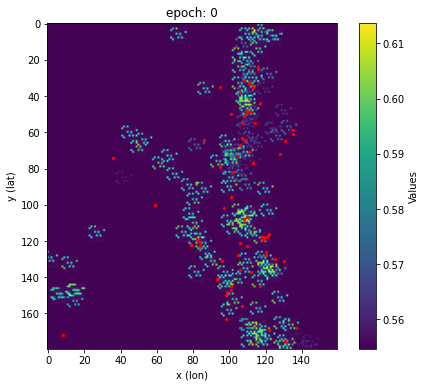

[1/7] | roc: 0.7697, roc_m: 0.7081, roc_w: 0.5566, epoch_loss: 0.8775, lr: 0.0500


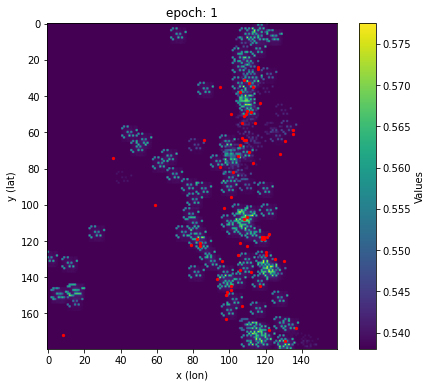

[2/7] | roc: 0.7441, roc_m: 0.6992, roc_w: 0.5664, epoch_loss: 0.7929, lr: 0.0250


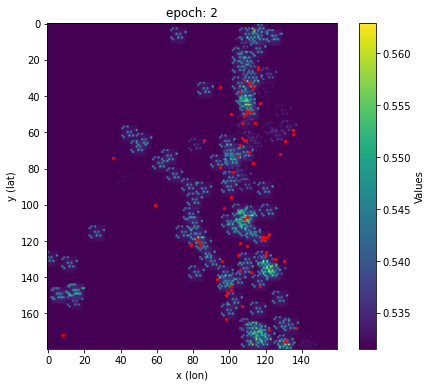

[3/7] | roc: 0.7308, roc_m: 0.6895, roc_w: 0.5704, epoch_loss: 0.7670, lr: 0.0125


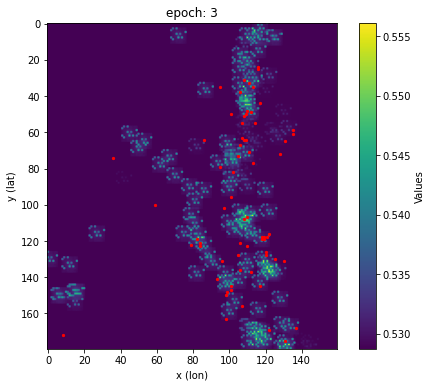

[4/7] | roc: 0.7844, roc_m: 0.71, roc_w: 0.5708, epoch_loss: 0.7568, lr: 0.0063


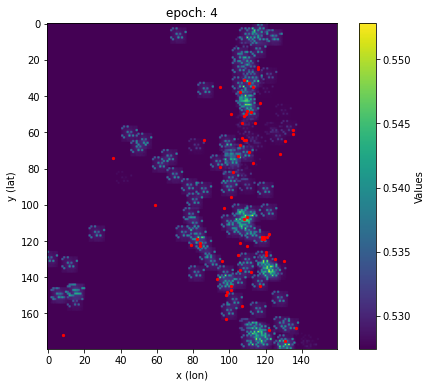

[5/7] | roc: 0.7231, roc_m: 0.6863, roc_w: 0.5733, epoch_loss: 0.7522, lr: 0.0031


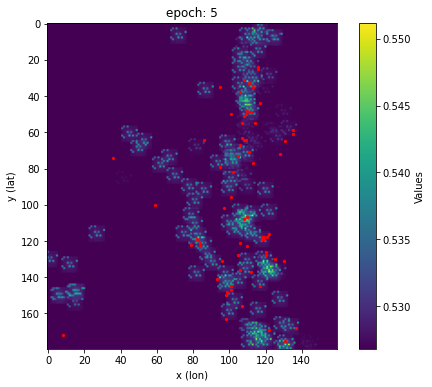

[6/7] | roc: 0.7892, roc_m: 0.7115, roc_w: 0.5709, epoch_loss: 0.7501, lr: 0.0016


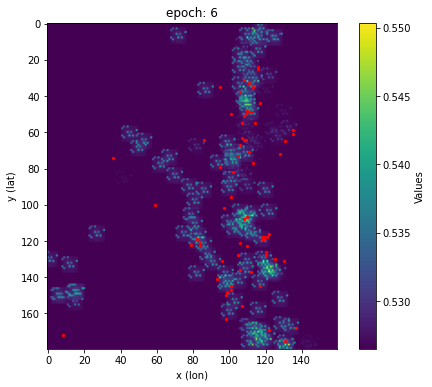

[7/7] | roc: 0.7732, roc_m: 0.7079, roc_w: 0.5719, epoch_loss: 0.7491, lr: 0.0008


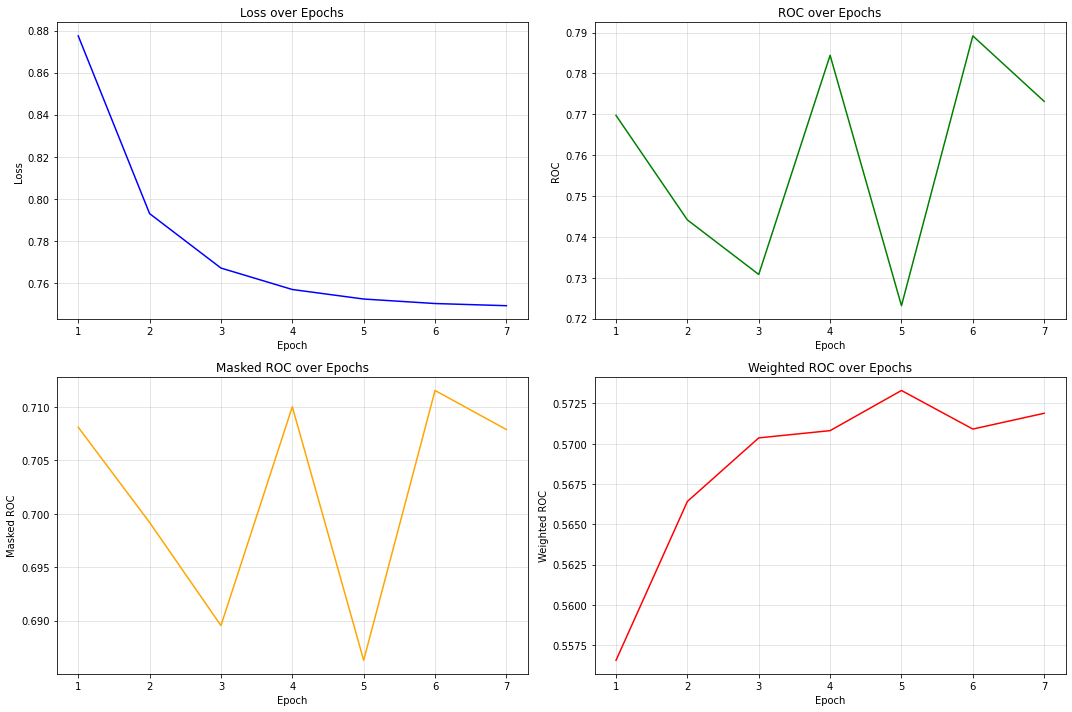

Best model saved with weighted ROC: 0.5733


In [197]:
device="cuda:0"
num_epochs=7
lr = 0.05

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(9, 9), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="orig35"
)

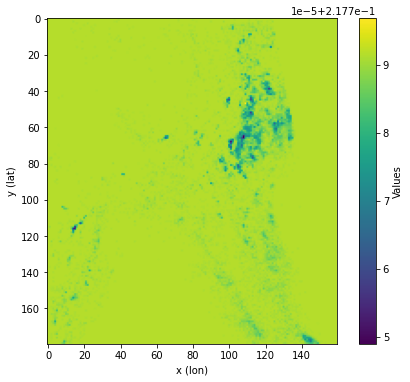

In [198]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

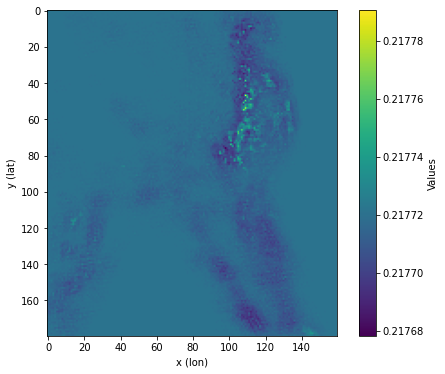

In [199]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

# m>3.5 without aftershocks

In [201]:
dataset_variant = dataset_variants[6]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"

target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/withoutfat_3.5_max', 'data/withoutfat_3.5_count')

In [ ]:
batch_size=1
stride=30
seq_len=1
history_horizon=64
sigma=10.0

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=sigma
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=sigma
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

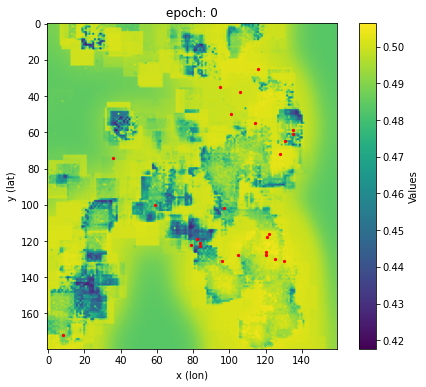

[1/10] | roc: 0.4936, roc_m: 0.6061, roc_w: 0.715, epoch_loss: 0.8153, lr: 0.0100


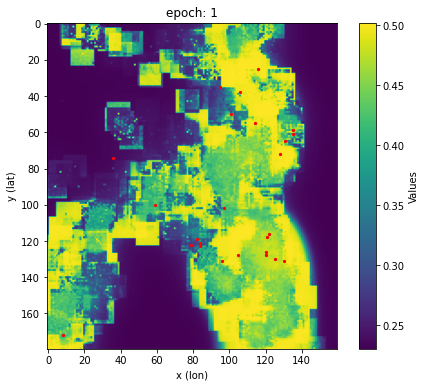

[2/10] | roc: 0.6999, roc_m: 0.6017, roc_w: 0.6695, epoch_loss: 0.5046, lr: 0.0070


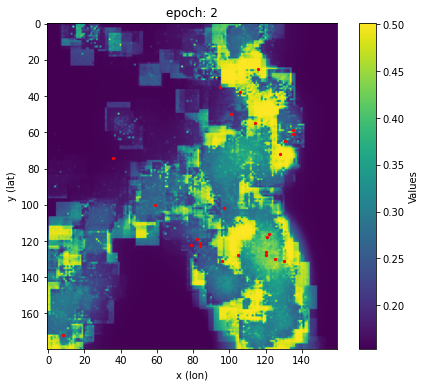

[3/10] | roc: 0.6872, roc_m: 0.5868, roc_w: 0.6362, epoch_loss: 0.2986, lr: 0.0049


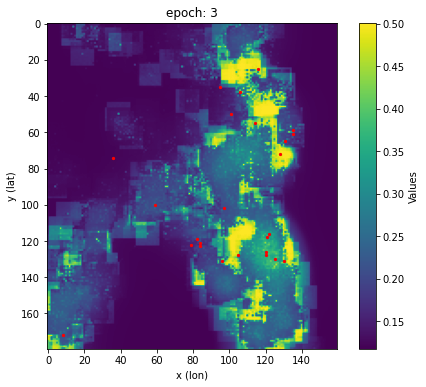

[4/10] | roc: 0.658, roc_m: 0.5873, roc_w: 0.6432, epoch_loss: 0.1930, lr: 0.0034


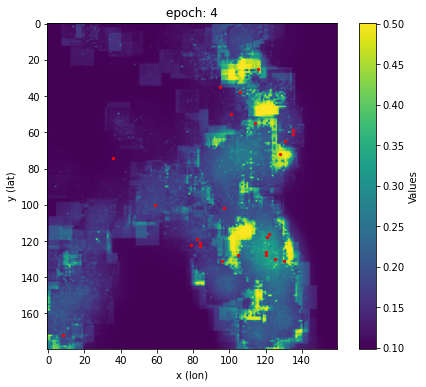

[5/10] | roc: 0.632, roc_m: 0.589, roc_w: 0.6557, epoch_loss: 0.1429, lr: 0.0024


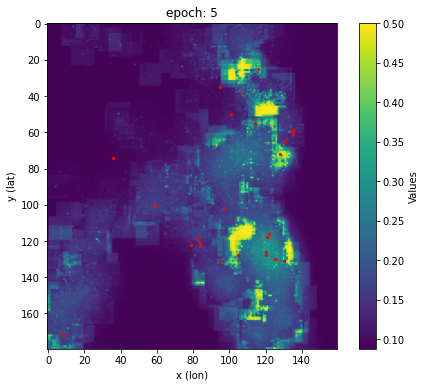

[6/10] | roc: 0.6155, roc_m: 0.5914, roc_w: 0.664, epoch_loss: 0.1175, lr: 0.0017


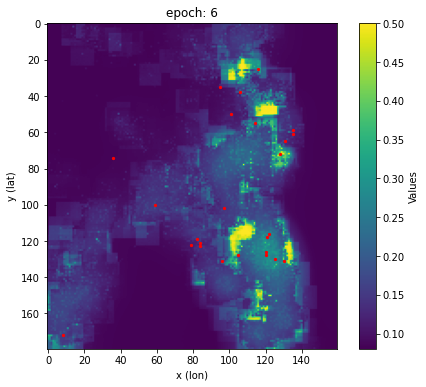

[7/10] | roc: 0.607, roc_m: 0.5933, roc_w: 0.6681, epoch_loss: 0.1032, lr: 0.0012


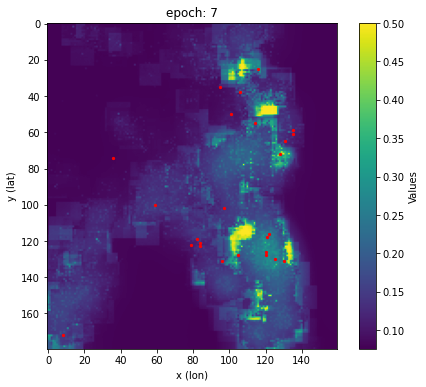

[8/10] | roc: 0.6025, roc_m: 0.595, roc_w: 0.6697, epoch_loss: 0.0945, lr: 0.0008


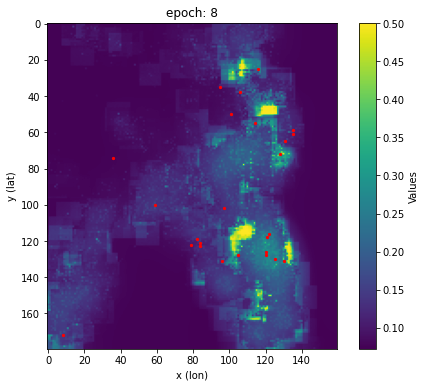

[9/10] | roc: 0.5988, roc_m: 0.5959, roc_w: 0.6702, epoch_loss: 0.0889, lr: 0.0006


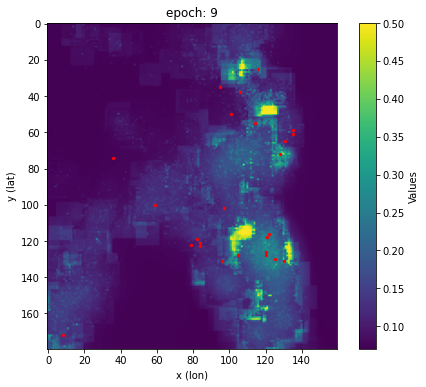

[10/10] | roc: 0.5973, roc_m: 0.5967, roc_w: 0.6702, epoch_loss: 0.0852, lr: 0.0004


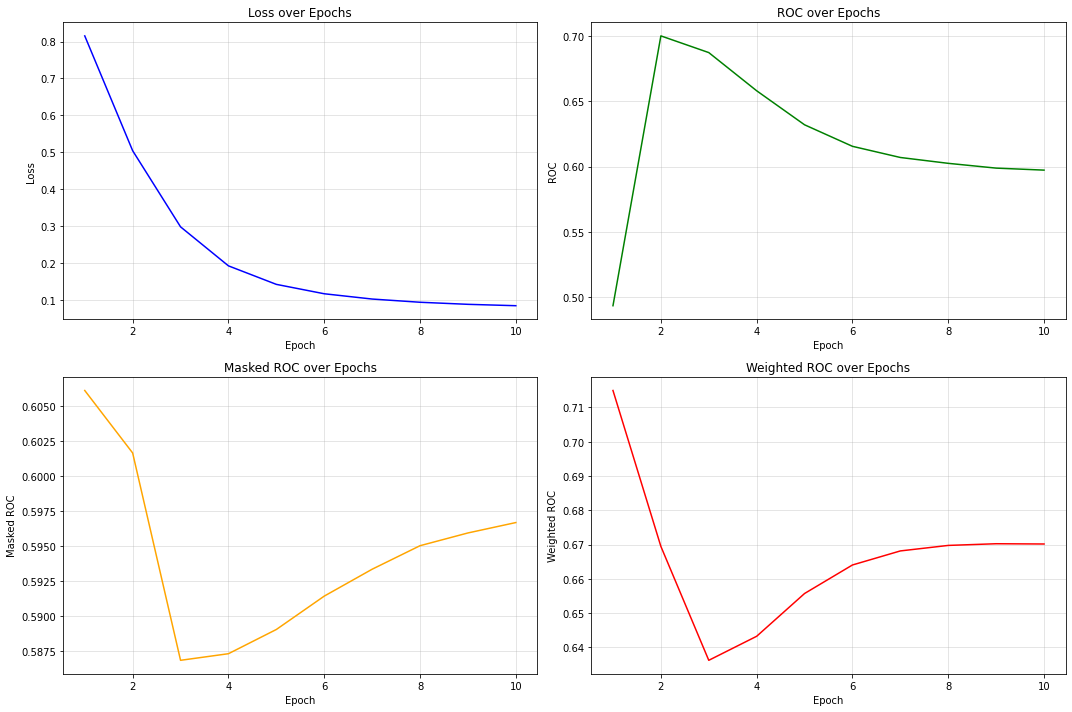

Best model saved with weighted ROC: 0.6702


In [210]:
device="cuda:0"
num_epochs=10
lr = 0.01

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(13, 13), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="withoutaft35"
)

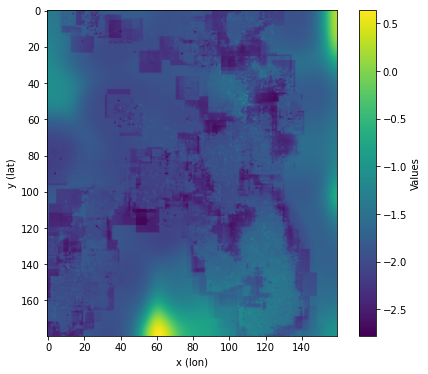

In [211]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

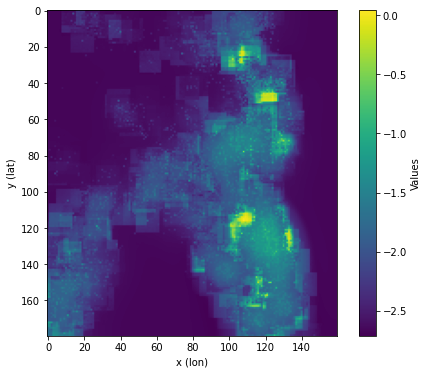

In [212]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

# M>6.0 mainshocks and aftershocks

In [213]:
dataset_variant = dataset_variants[10]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/orig_6.0_max', 'data/orig_6.0_count')

In [214]:
batch_size=1
stride=30
seq_len=1
history_horizon=64
sigma=1.5

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=sigma
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=sigma
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

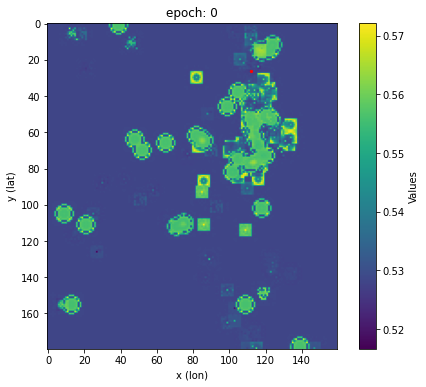

[1/10] | roc: 0.6518, roc_m: 0.6286, roc_w: 0.4537, epoch_loss: 0.8480, lr: 0.0050


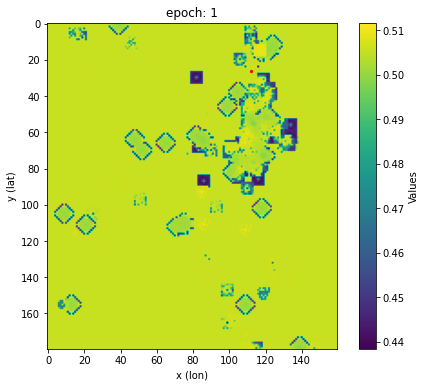

[2/10] | roc: 0.5449, roc_m: 0.5718, roc_w: 0.6005, epoch_loss: 0.7285, lr: 0.0035


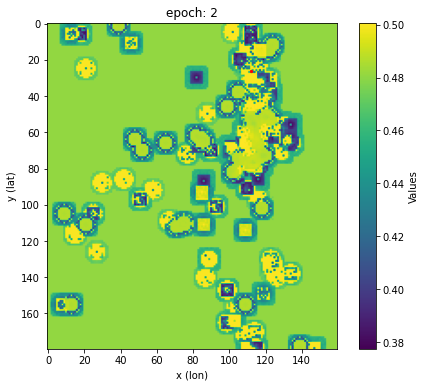

[3/10] | roc: 0.6322, roc_m: 0.6668, roc_w: 0.5341, epoch_loss: 0.6807, lr: 0.0024


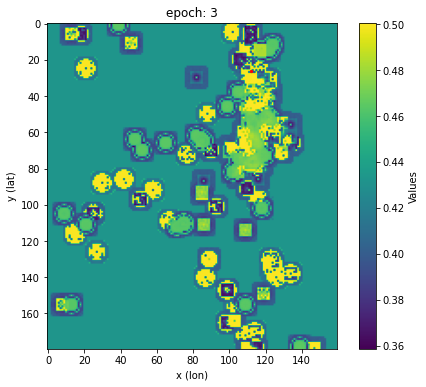

[4/10] | roc: 0.6859, roc_m: 0.693, roc_w: 0.4928, epoch_loss: 0.6092, lr: 0.0017


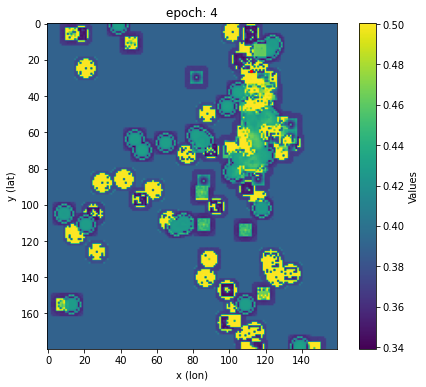

[5/10] | roc: 0.6811, roc_m: 0.6863, roc_w: 0.4808, epoch_loss: 0.5398, lr: 0.0012


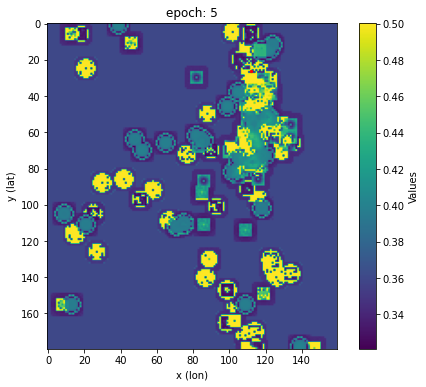

[6/10] | roc: 0.6818, roc_m: 0.688, roc_w: 0.483, epoch_loss: 0.4875, lr: 0.0008


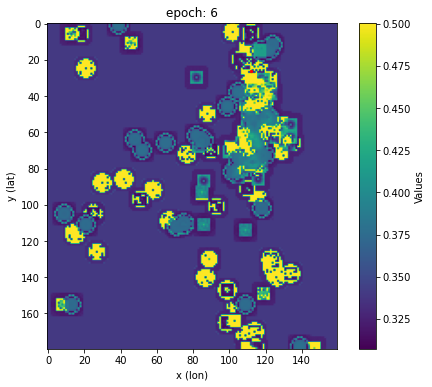

[7/10] | roc: 0.6808, roc_m: 0.6856, roc_w: 0.4824, epoch_loss: 0.4522, lr: 0.0006


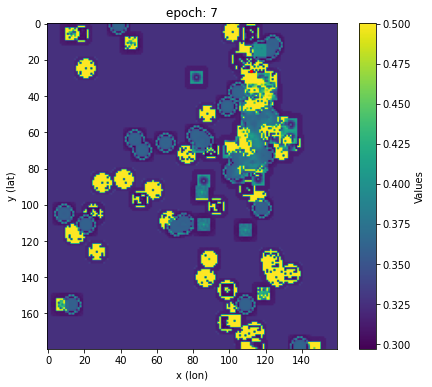

[8/10] | roc: 0.6804, roc_m: 0.686, roc_w: 0.4838, epoch_loss: 0.4288, lr: 0.0004


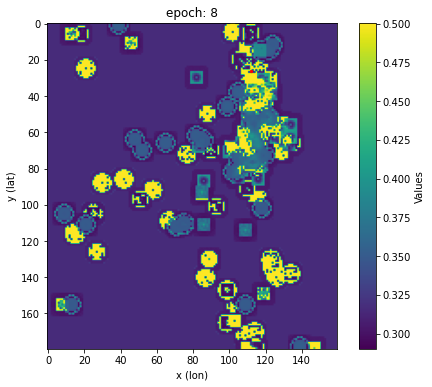

[9/10] | roc: 0.6795, roc_m: 0.6847, roc_w: 0.4835, epoch_loss: 0.4133, lr: 0.0003


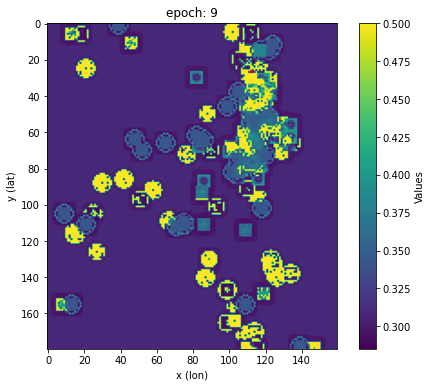

[10/10] | roc: 0.6791, roc_m: 0.6848, roc_w: 0.4846, epoch_loss: 0.4029, lr: 0.0002


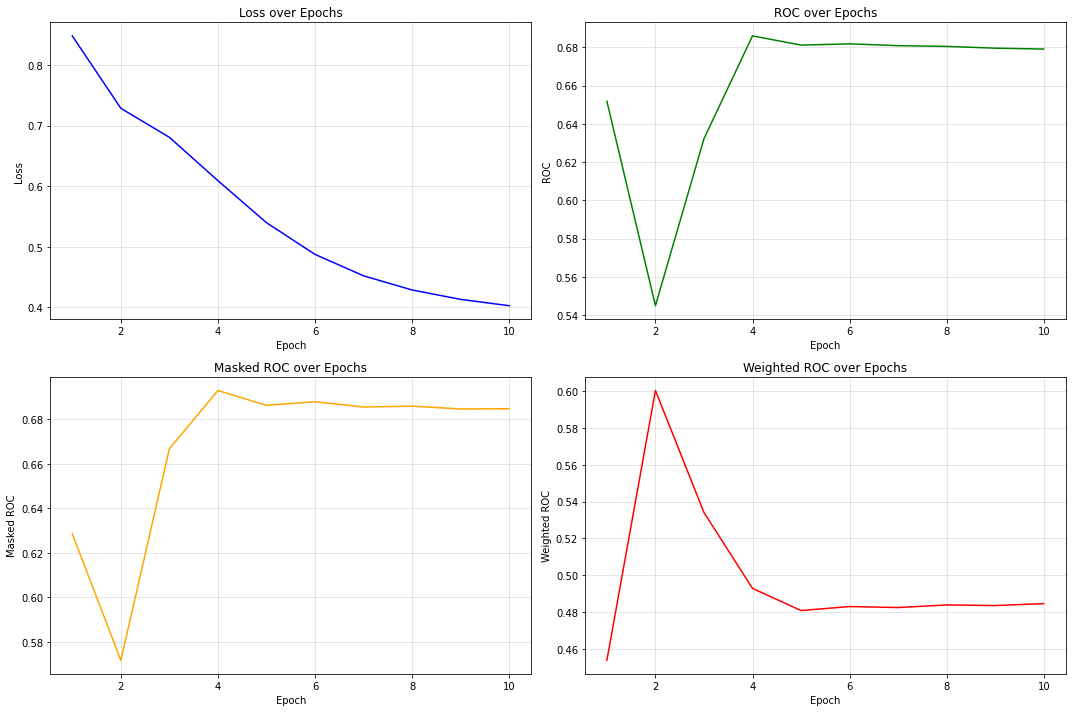

Best model saved with weighted ROC: 0.6005


In [249]:
device="cuda:0"
num_epochs=3
lr = 0.005

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="orig60", min_save_epoch=1
)

In [261]:
model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
model_state = torch.load("model/orig60.pth")
model.load_state_dict(model_state)
model.eval()

EarthquakePredictionModel(
  (convlstm): ConvLSTM(
    (cell_list): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(65, 256, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
      )
    )
  )
  (layer_norm_lstm): LayerNorm((64, 160, 180), eps=1e-05, elementwise_affine=True)
  (conv1x1): Conv2d(65, 1, kernel_size=(1, 1), stride=(1, 1))
  (layer_norm_conv): LayerNorm((1, 160, 180), eps=1e-05, elementwise_affine=True)
  (activation): Sigmoid()
)

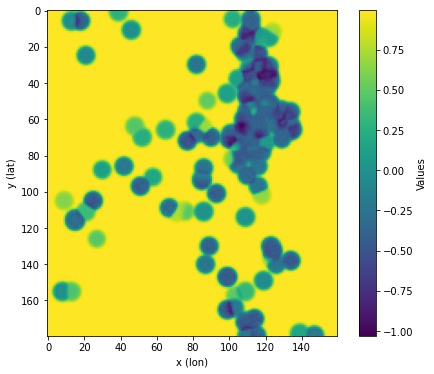

In [262]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

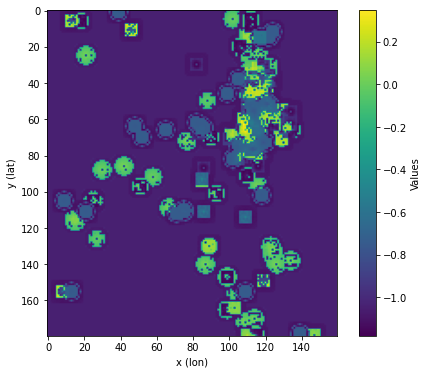

In [263]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

## input -- with aftershocks >3.5 max magnitude

In [31]:
dataset_variant = dataset_variants[2]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
dataset_variant = dataset_variants[10]
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/orig_3.5_max', 'data/orig_6.0_count')

In [32]:
batch_size=1
stride=30
seq_len=1
history_horizon=64
sigma=1.5

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=sigma
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=sigma
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

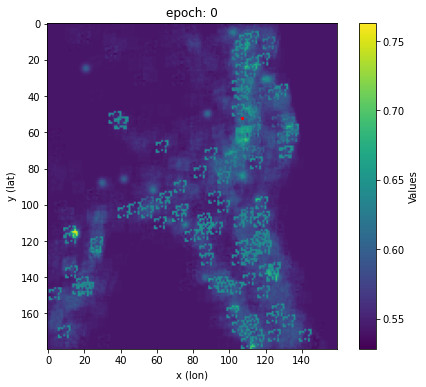

[1/7] | roc: 0.8438, roc_m: 0.7503, roc_w: 0.5455, epoch_loss: 0.8881, lr: 0.0030


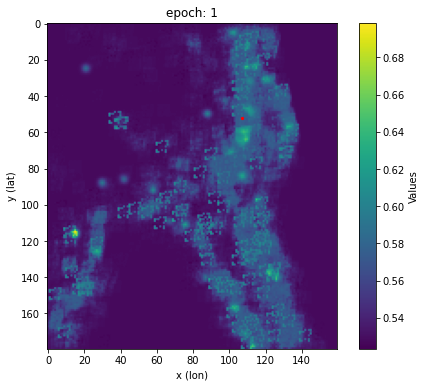

[2/7] | roc: 0.8594, roc_m: 0.7739, roc_w: 0.5767, epoch_loss: 0.8018, lr: 0.0012


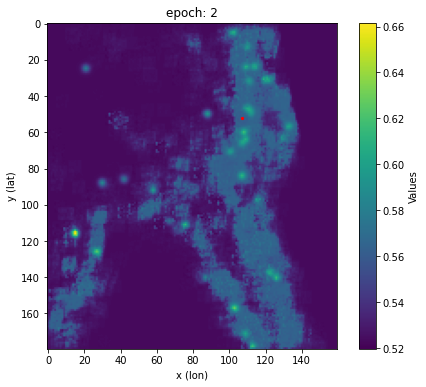

[3/7] | roc: 0.8671, roc_m: 0.7847, roc_w: 0.5739, epoch_loss: 0.7744, lr: 0.0005


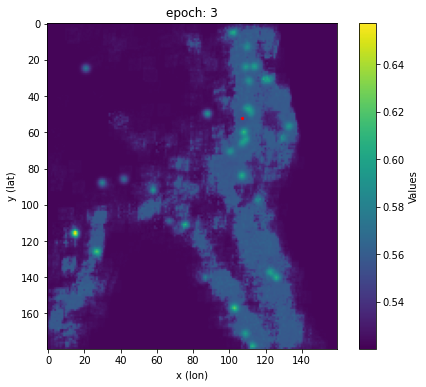

[4/7] | roc: 0.8659, roc_m: 0.7823, roc_w: 0.5641, epoch_loss: 0.7645, lr: 0.0002


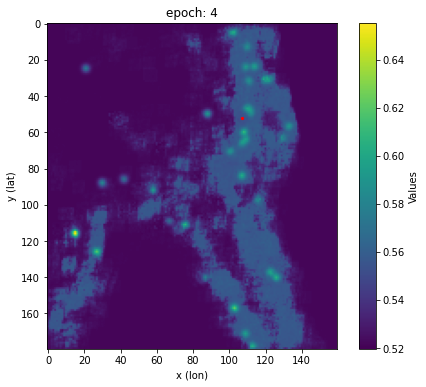

[5/7] | roc: 0.8622, roc_m: 0.7777, roc_w: 0.5572, epoch_loss: 0.7607, lr: 0.0001


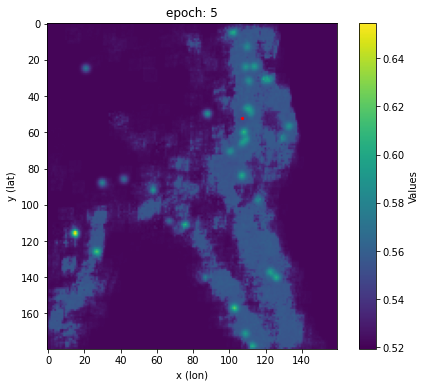

[6/7] | roc: 0.8715, roc_m: 0.7802, roc_w: 0.5589, epoch_loss: 0.7592, lr: 0.0000


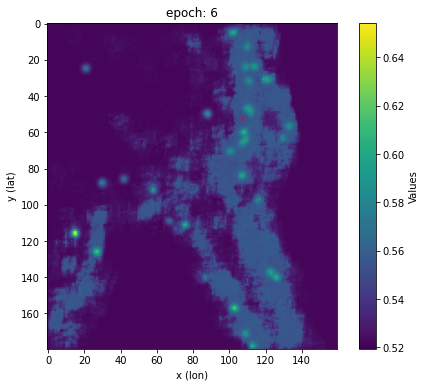

[7/7] | roc: 0.8674, roc_m: 0.7667, roc_w: 0.5442, epoch_loss: 0.7586, lr: 0.0000


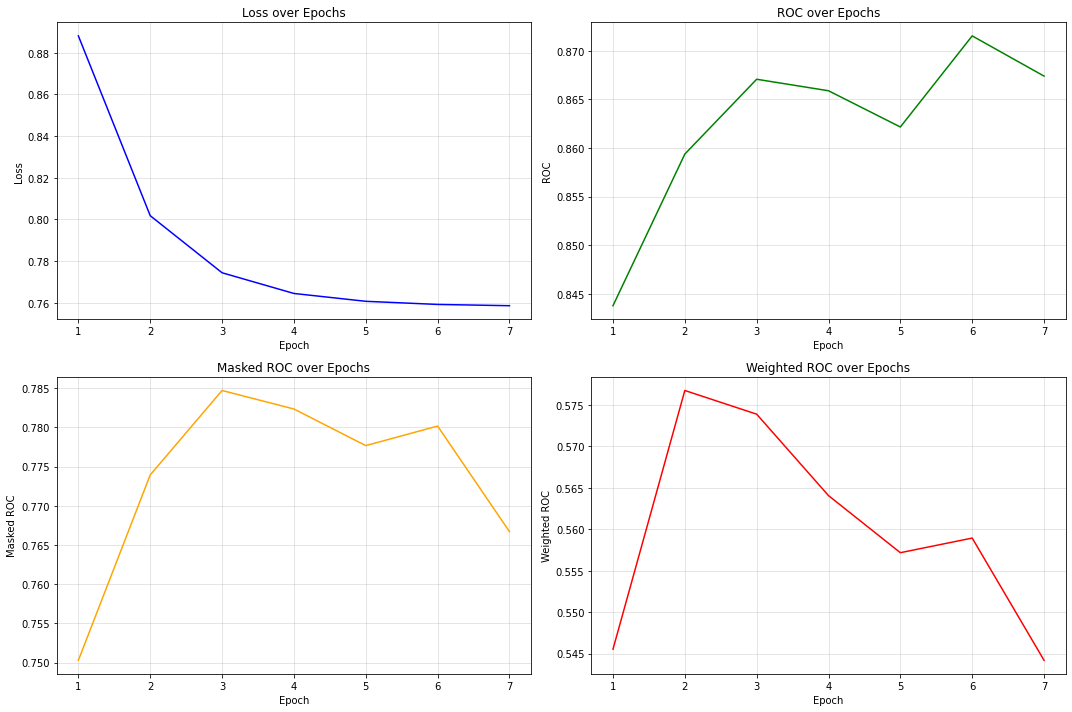

Best model saved with weighted ROC: 0.5767


In [45]:
device="cuda:0"
num_epochs=7
lr = 0.003

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.1, weight_decay=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=0.4)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="orig60_input35", min_save_epoch=1
)

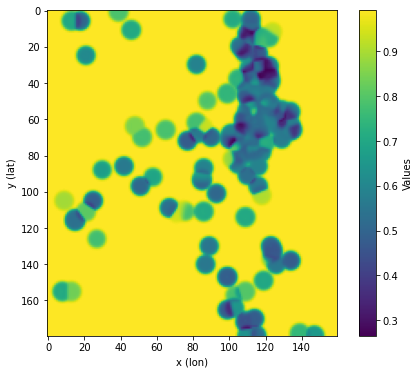

In [46]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

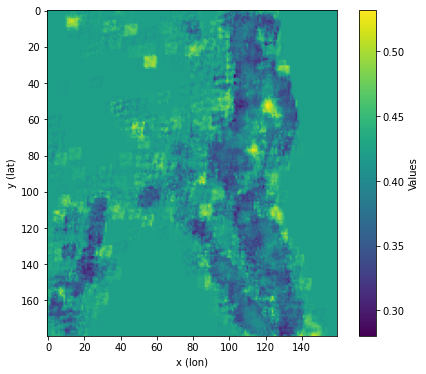

In [47]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

# M>6.0 without aftershocks

In [265]:
dataset_variant = dataset_variants[12]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/withoutfat_6.0_count', 'data/withoutfat_6.0_count')

In [266]:
batch_size=1
stride=30
seq_len=1
history_horizon=64
sigma=0.1

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=sigma
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=sigma
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

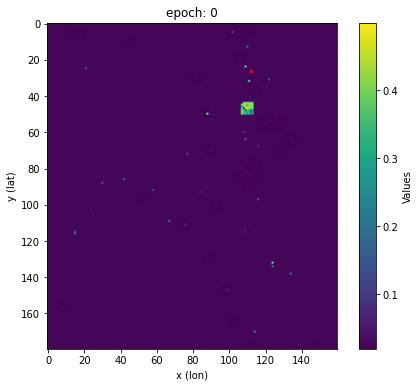

[1/10] | roc: 0.6966, roc_m: 0.737, roc_w: 0.6549, epoch_loss: 0.1074, lr: 0.2500


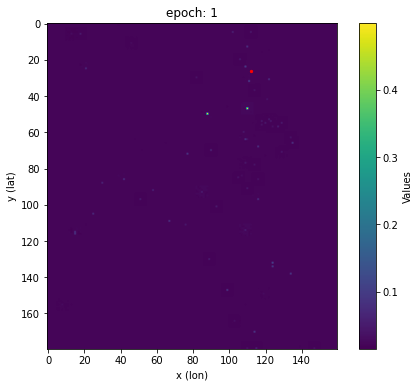

[2/10] | roc: 0.517, roc_m: 0.5349, roc_w: 0.5464, epoch_loss: 0.0245, lr: 0.0500


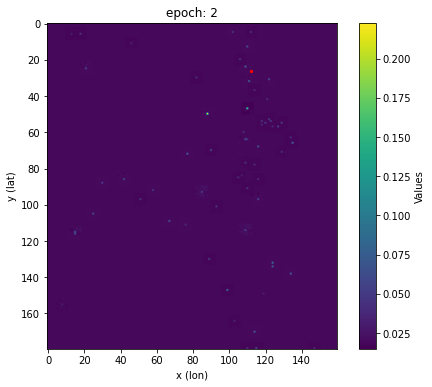

[3/10] | roc: 0.5811, roc_m: 0.6121, roc_w: 0.6252, epoch_loss: 0.0210, lr: 0.0100


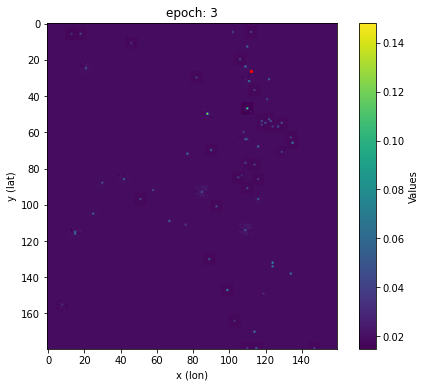

[4/10] | roc: 0.519, roc_m: 0.5402, roc_w: 0.5801, epoch_loss: 0.0198, lr: 0.0020


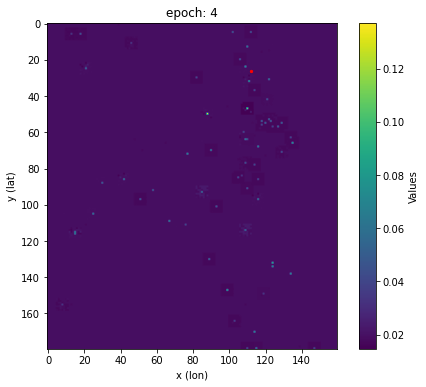

[5/10] | roc: 0.5193, roc_m: 0.5407, roc_w: 0.581, epoch_loss: 0.0194, lr: 0.0004


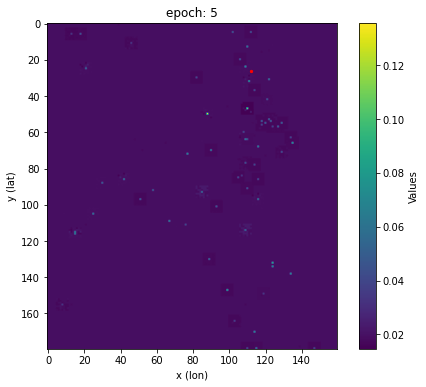

[6/10] | roc: 0.5195, roc_m: 0.5412, roc_w: 0.5822, epoch_loss: 0.0193, lr: 0.0001


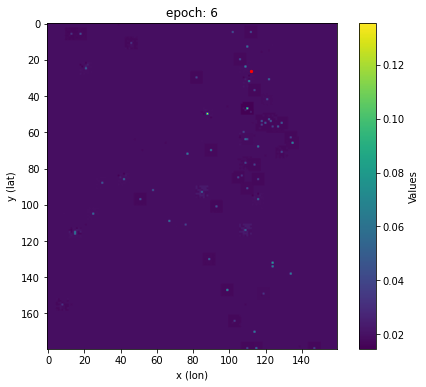

[7/10] | roc: 0.5196, roc_m: 0.5414, roc_w: 0.5823, epoch_loss: 0.0193, lr: 0.0000


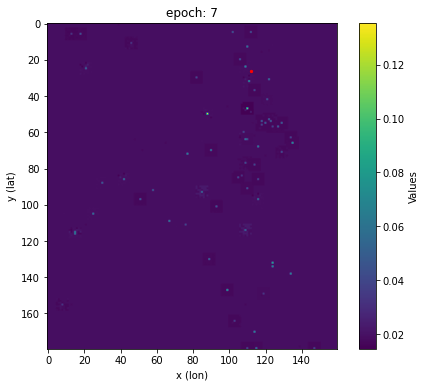

[8/10] | roc: 0.5196, roc_m: 0.5414, roc_w: 0.5823, epoch_loss: 0.0193, lr: 0.0000


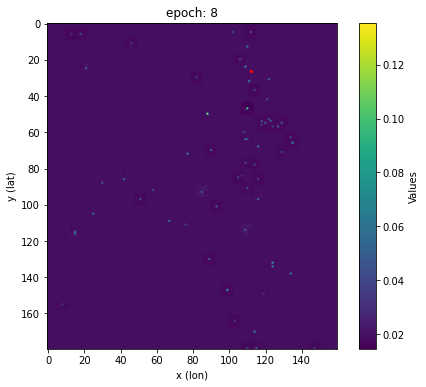

[9/10] | roc: 0.5196, roc_m: 0.5414, roc_w: 0.5823, epoch_loss: 0.0193, lr: 0.0000


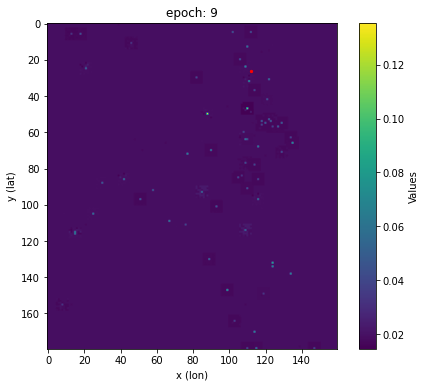

[10/10] | roc: 0.5196, roc_m: 0.5414, roc_w: 0.5823, epoch_loss: 0.0193, lr: 0.0000


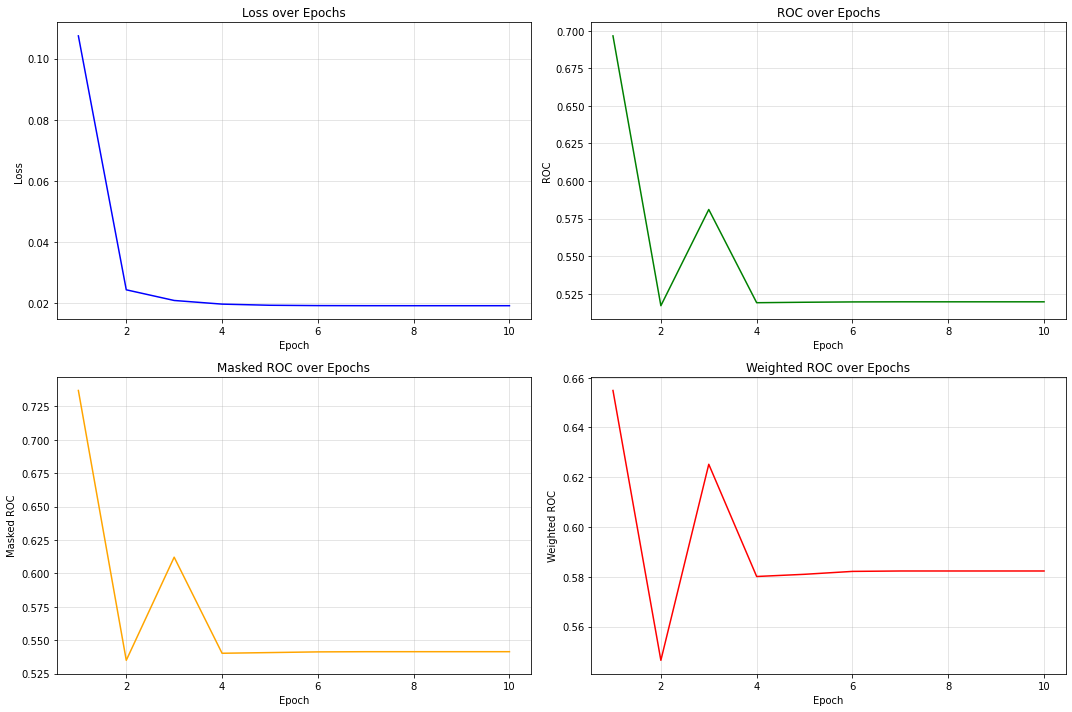

Best model saved with weighted ROC: 0.6252


In [276]:
device="cuda:0"
num_epochs=10
lr = 0.25

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.2)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="withoutaft60"
)

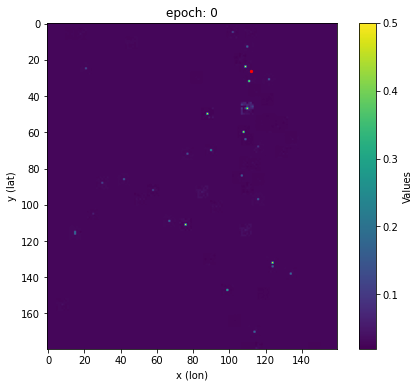

[1/10] | roc: 0.4222, roc_m: 0.4233, roc_w: 0.5039, epoch_loss: 0.1261, lr: 0.2000


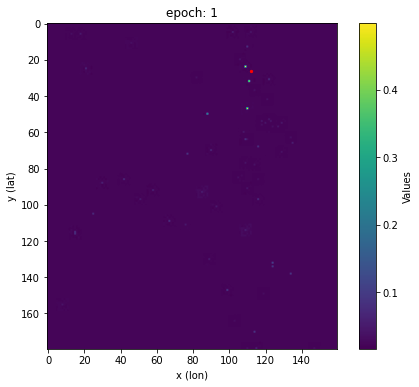

[2/10] | roc: 0.422, roc_m: 0.4265, roc_w: 0.5146, epoch_loss: 0.0264, lr: 0.0500


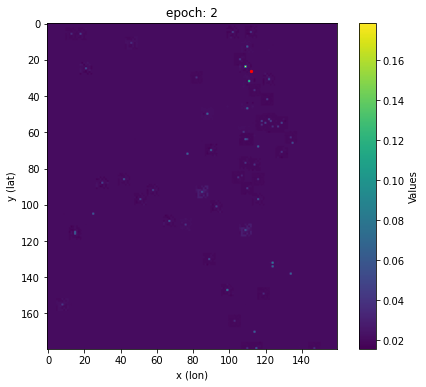

[3/10] | roc: 0.4216, roc_m: 0.4241, roc_w: 0.5091, epoch_loss: 0.0225, lr: 0.0125


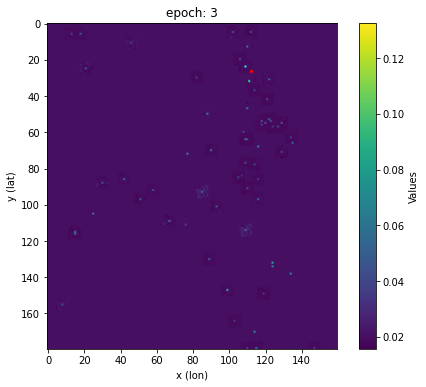

[4/10] | roc: 0.6258, roc_m: 0.6502, roc_w: 0.6192, epoch_loss: 0.0209, lr: 0.0031


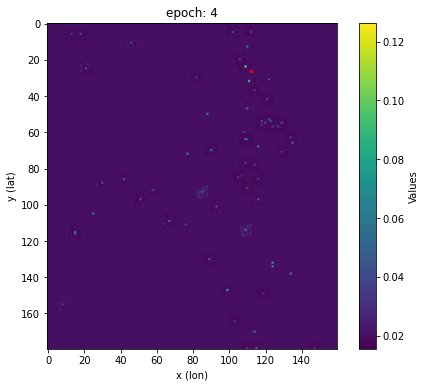

[5/10] | roc: 0.541, roc_m: 0.5597, roc_w: 0.5882, epoch_loss: 0.0204, lr: 0.0008


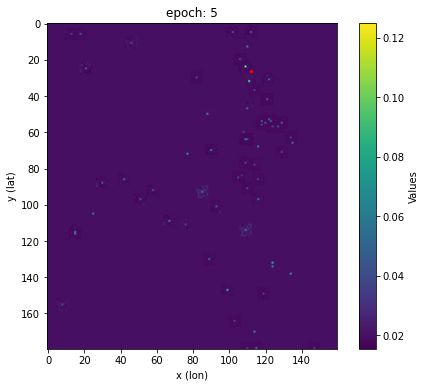

[6/10] | roc: 0.4808, roc_m: 0.4918, roc_w: 0.551, epoch_loss: 0.0202, lr: 0.0002


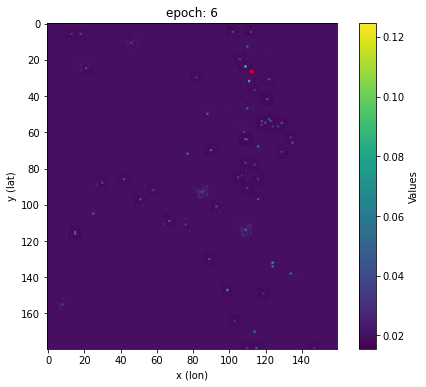

[7/10] | roc: 0.4812, roc_m: 0.4925, roc_w: 0.5518, epoch_loss: 0.0201, lr: 0.0000


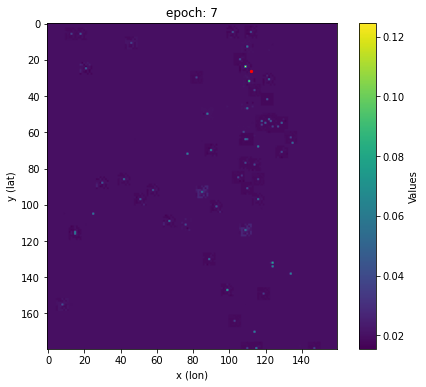

[8/10] | roc: 0.4813, roc_m: 0.4928, roc_w: 0.552, epoch_loss: 0.0201, lr: 0.0000


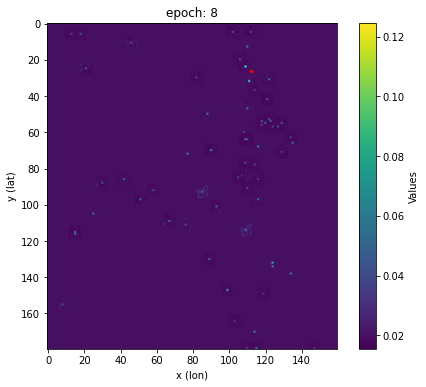

[9/10] | roc: 0.4813, roc_m: 0.4928, roc_w: 0.552, epoch_loss: 0.0201, lr: 0.0000


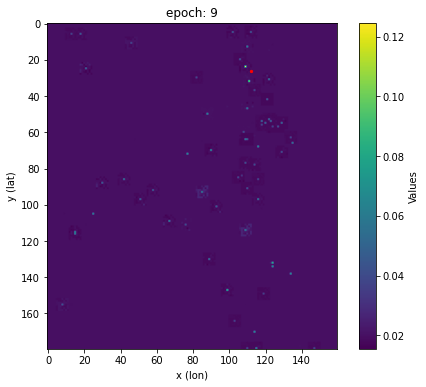

[10/10] | roc: 0.4813, roc_m: 0.4928, roc_w: 0.552, epoch_loss: 0.0201, lr: 0.0000


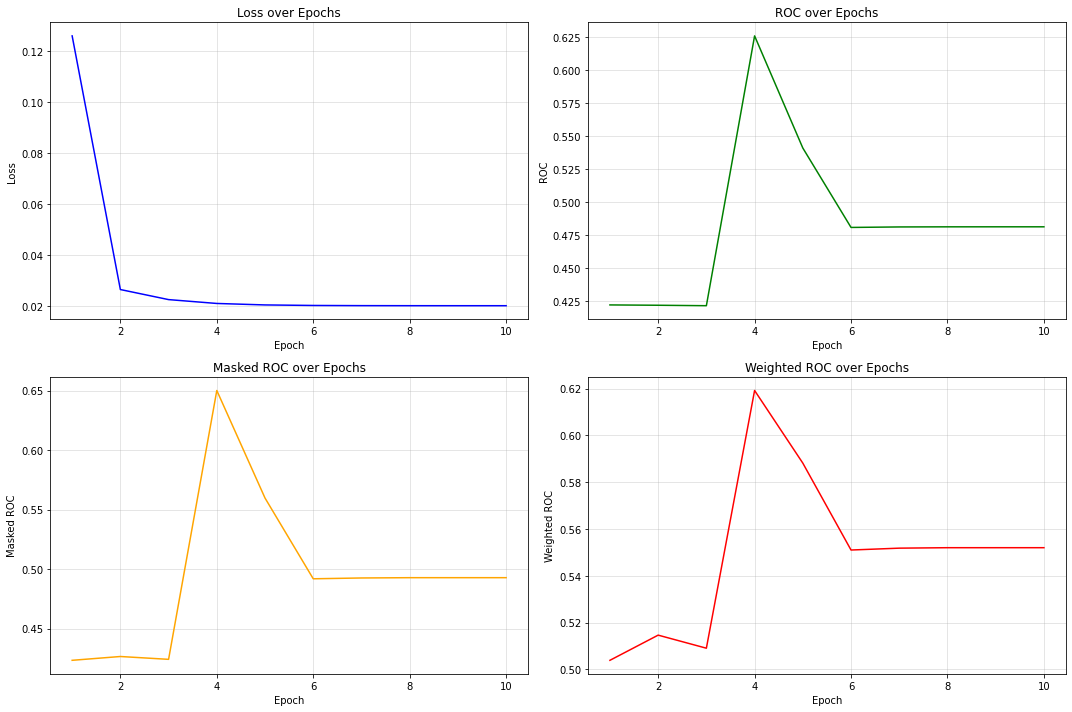

Best model saved with weighted ROC: 0.6192


In [285]:
device="cuda:0"
num_epochs=10
lr = 0.2

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.25)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="withoutaft60_"
)

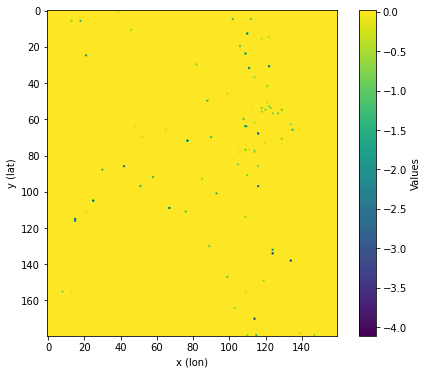

In [286]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

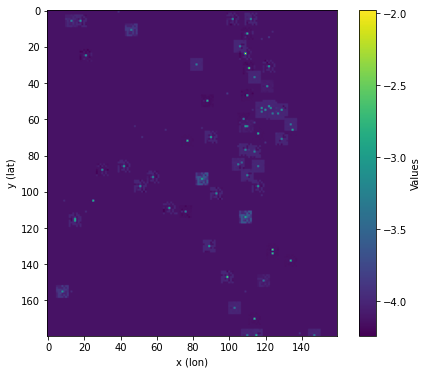

In [287]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

## input -- withoutfat aftershocks >3.5 max magnitude

In [18]:
dataset_variant = dataset_variants[6]
pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_{dataset_variant['mode']}"
dataset_variant = dataset_variants[12]
target_pn = f"data/{dataset_variant['data_type']}_{dataset_variant['min_magn']}_count"
pn, target_pn

('data/withoutfat_3.5_max', 'data/withoutfat_6.0_count')

In [19]:
batch_size=1
stride=30
seq_len=1
history_horizon=64
sigma=0.1

train_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, seq_len=seq_len, stride=stride, dataset_type="train", 
    history_horizon=history_horizon, sigma=sigma
)
test_dataset = EarthquakeDataset(
    path=pn, target_path=target_pn, history_horizon=history_horizon,
    x_min=train_dataset.x_min, x_max=train_dataset.x_max, 
    seq_len=seq_len, stride=stride, dataset_type="test", sigma=sigma
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

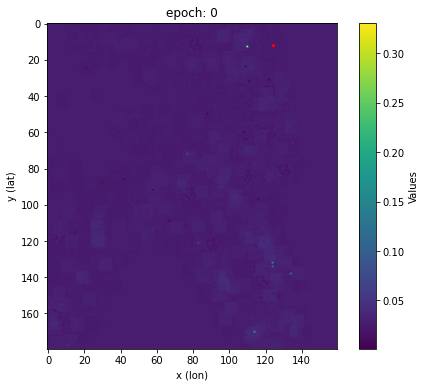

[1/10] | roc: 0.7354, roc_m: 0.637, roc_w: 0.6513, epoch_loss: 0.1005, lr: 0.2500


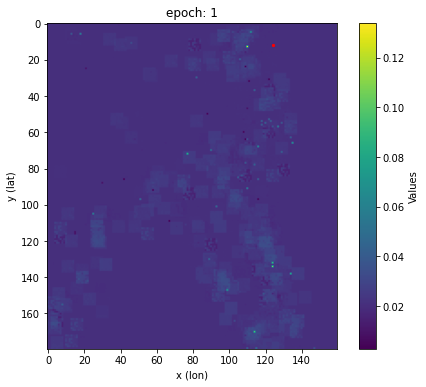

[2/10] | roc: 0.7363, roc_m: 0.6394, roc_w: 0.6521, epoch_loss: 0.0247, lr: 0.0500


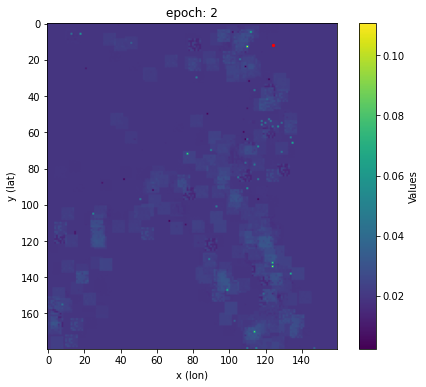

[3/10] | roc: 0.729, roc_m: 0.6157, roc_w: 0.6349, epoch_loss: 0.0212, lr: 0.0100


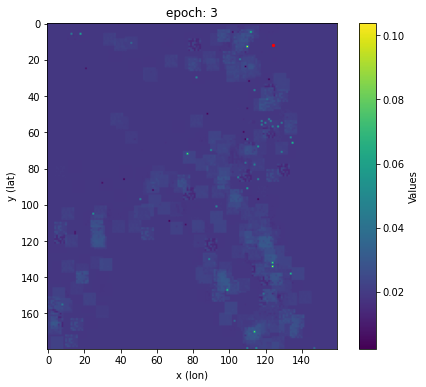

[4/10] | roc: 0.7418, roc_m: 0.6488, roc_w: 0.6604, epoch_loss: 0.0200, lr: 0.0020


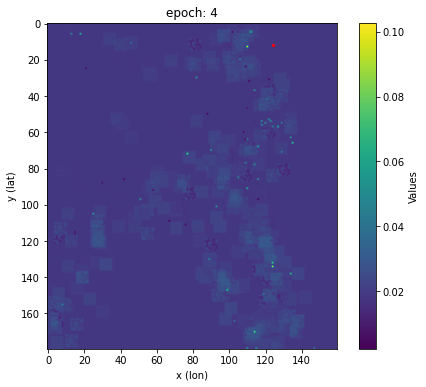

[5/10] | roc: 0.6813, roc_m: 0.5993, roc_w: 0.623, epoch_loss: 0.0197, lr: 0.0004


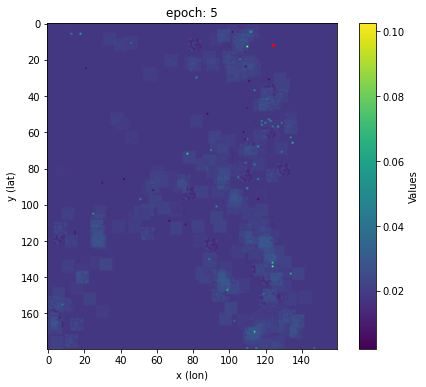

[6/10] | roc: 0.6838, roc_m: 0.6032, roc_w: 0.6271, epoch_loss: 0.0195, lr: 0.0001


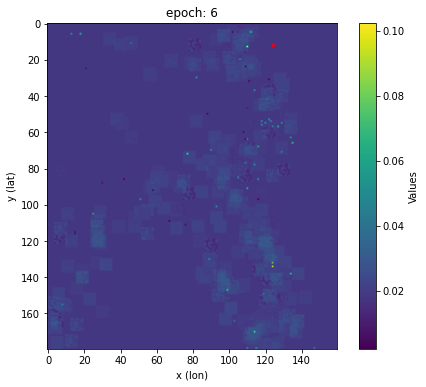

[7/10] | roc: 0.6845, roc_m: 0.6044, roc_w: 0.6279, epoch_loss: 0.0195, lr: 0.0000


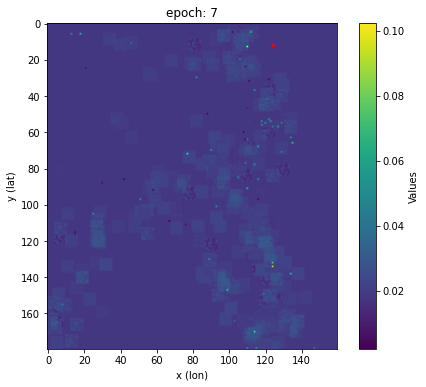

[8/10] | roc: 0.6847, roc_m: 0.6047, roc_w: 0.6281, epoch_loss: 0.0195, lr: 0.0000


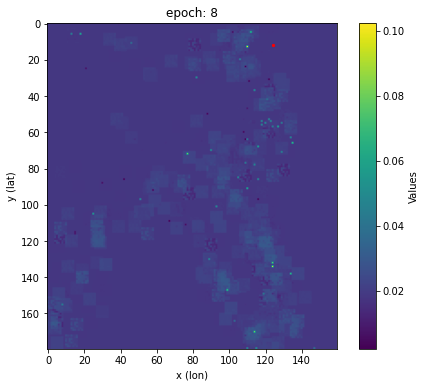

[9/10] | roc: 0.6847, roc_m: 0.6047, roc_w: 0.6281, epoch_loss: 0.0195, lr: 0.0000


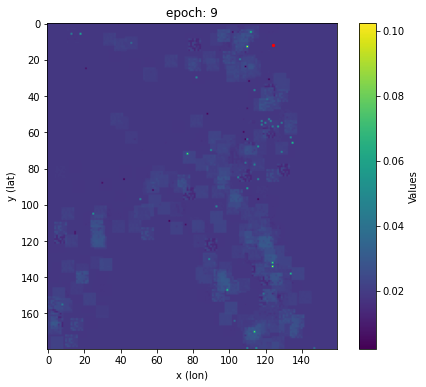

[10/10] | roc: 0.6847, roc_m: 0.6047, roc_w: 0.6281, epoch_loss: 0.0195, lr: 0.0000


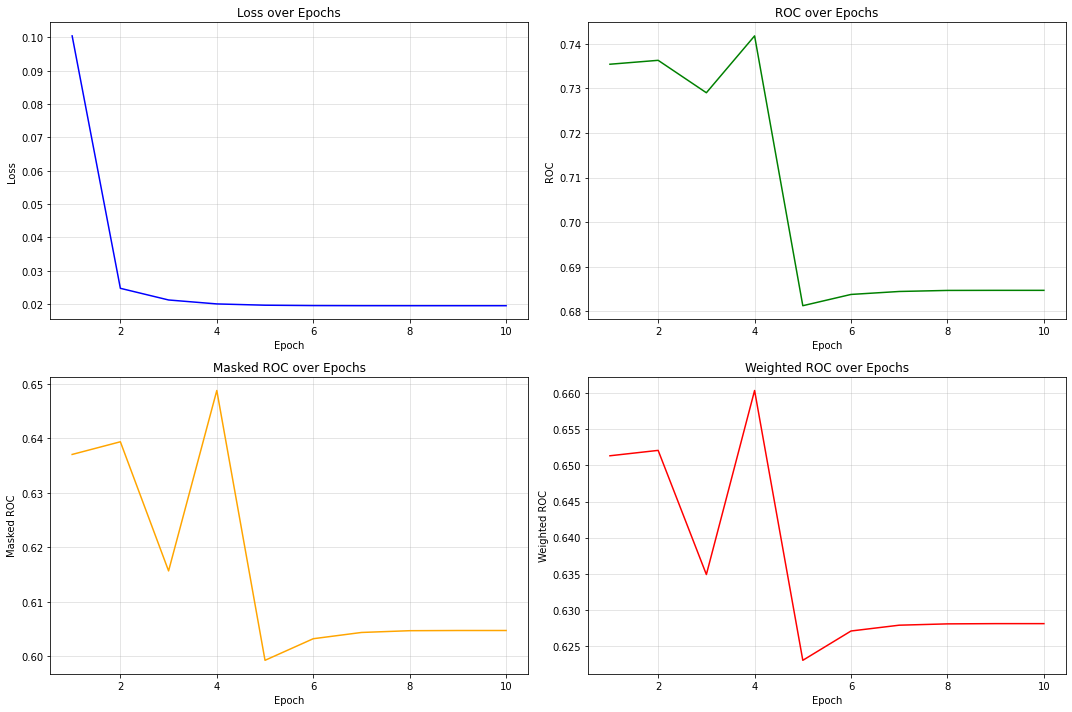

Best model saved with weighted ROC: 0.6604


In [24]:
device="cuda:0"
num_epochs=10
lr = 0.25

model = EarthquakePredictionModel(
    seq_len=1, input_dim=1, hidden_dim=[64], kernel_size=(7, 7), num_layers=1
).to(device)
criterion = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5, weight_decay=0.01)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=0.1)
scheduler = StepLR(optimizer, step_size=1, gamma=0.2)

_ = train_model(
    model, train_loader, test_loader, criterion, optimizer, device, 
    num_epochs, sample_weight, scheduler, use_amp=True, model_name="withoutaft60_input35"
)

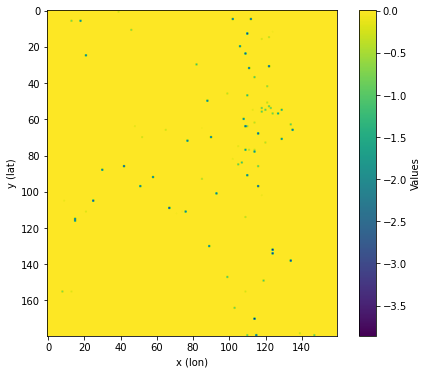

In [25]:
array = (model.w1.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()

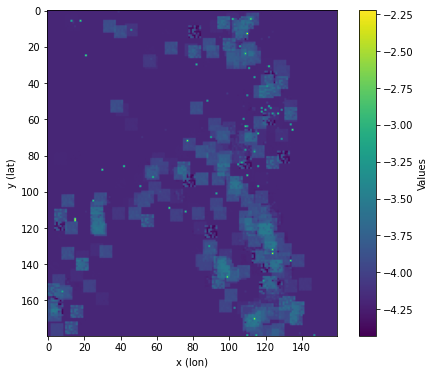

In [26]:
array = (model.w2.cpu().detach().transpose(0, 1)).numpy()[::-1]
plt.figure(figsize=(8, 6))
plt.imshow(array, cmap='viridis')
plt.colorbar(label='Values')
plt.xlabel('x (lon)')
plt.ylabel('y (lat)')
plt.show()